In [2]:
#linhongbojob@163.com 
#coding:utf-8
from rdkit import Chem,DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
import numpy as np
from keras import layers
from keras.layers import Input,Dense,Activation,Dropout
from keras.models import Sequential
from keras.models import load_model
import pandas as pd
from numpy.linalg import *
from sklearn import metrics
import matplotlib
from matplotlib import pyplot as plt
import pickle
import cirpy

In [3]:
#get smiles by cas
def smile_cirpy(cas,out):
    try:
        smi=cirpy.resolve(cas,out)#
    except:
        return 'cirpy error'
    return smi

In [4]:
#normalize
def nor(rawdata):
    r=rawdata*0.01
    r_r=np.round(r,1)
    return r_r

In [5]:
#convert smiles to maccs fingerprint
def smilestomaccs(smile):
    mol = Chem.MolFromSmiles(smile)
    fps=MACCSkeys.GenMACCSKeys(mol)
    fp_arr=np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fps,fp_arr)
    return np.array(fp_arr)


In [6]:
#read file. 50 lines for manual testing. shuffled was done before
def readdata(xlsx_data):
    df_raw=pd.read_excel(xlsx_data)
    print('rawdata：',df_raw.shape)
    train_data=df_raw.iloc[50:,3553:]
    print("traindata：",train_data.shape)
    y_data=df_raw.iloc[50:,201:3552]
    print("targetdata：",y_data.shape)
    test_x=df_raw.iloc[:50,3553:]
    test_y=df_raw.iloc[:50,201:3552]
    return np.array(train_data),np.array(y_data),np.array(test_x),np.array(test_y)

In [7]:
#Least square method for solving matrix equations AX=B，where A--maccs matrix,B--sepctra matrix,X--what we want
def least_sqaure_method(matrix_a,matrix_b):
    r_lsm = np.linalg.lstsq(matrix_a, matrix_b, rcond=None)[0]
    #calculate Mean Square Error
    MSE_np=metrics.mean_squared_error(matrix_a.dot(r_lsm), matrix_b)
    print('lsm mse：',MSE_np)
    return r_lsm

In [23]:
#model
def multi_layer(matrix_a,matrix_b,steps,logfile,modelfile):
    model=Sequential()
    model.add(Dense(2000,input_dim=matrix_a.shape[1],activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(5000,activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4000,activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(matrix_b.shape[1]))
    model.summary()
    model.compile(optimizer='Adam',loss='mse',metrics=['accuracy'])
    history=model.fit(matrix_a,matrix_b,epochs=steps,batch_size=256, validation_split=0.2)
    model.save(modelfile+'.h5')
    filename=logfile+'.txt'
    with open (filename,'wb+') as file:
        pickle.dump(history,file)
    plt.plot(range(steps),history.history['loss'])
    plt.plot(range(steps),history.history['accuracy'])
    plt.show()
    return 'finished！'
    

In [9]:
#generate spectra from maccs using existed model or lsm result
def cal_spectra(key,m_r,realdata):
    if '.h5' not in str(m_r):
        yt=key.dot(m_r)
    else:
        model = load_model(m_r)
        try:
            key=key.reshape(1,-1)
            yt=model.predict(key)
        except:
            yt=model.predict(key)            
        yt=yt.reshape(-1,1)
    xt=np.arange(650,4001)
    plt.figure(figsize=(8,3),dpi=100)
    plt.rcParams['axes.unicode_minus']=False
    plt.title("IR_Compare")
    plt.xlabel("wave number")
    plt.gca().invert_xaxis()
    plt.ylabel("absorbance")
    plt.plot(xt,yt,label='predict',linewidth=0.5)
    plt.plot(xt,realdata,label='real',linewidth=0.5)
    plt.legend()
    plt.show()
    return
    

In [10]:
X,Y,TX,TY=readdata('0313.xlsx')

rawdata： (11610, 3719)
traindata： (11560, 166)
targetdata： (11560, 3351)


In [11]:
Y1=nor(Y)

In [12]:
r_lsm=least_sqaure_method(X,Y1)
print(r_lsm.shape)

lsm mse： 0.026018567182479732
(166, 3351)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 2000)              334000    
                                                                 
 dropout_16 (Dropout)        (None, 2000)              0         
                                                                 
 dense_21 (Dense)            (None, 5000)              10005000  
                                                                 
 dropout_17 (Dropout)        (None, 5000)              0         
                                                                 
 dense_22 (Dense)            (None, 4000)              20004000  
                                                                 
 dropout_18 (Dropout)        (None, 4000)              0         
                                                                 
 dense_23 (Dense)            (None, 3351)             

37/37 [==============================] - 12s 334ms/step - loss: 0.0121 - accuracy: 0.0174 - val_loss: 0.0227 - val_accuracy: 0.0151
Epoch 49/50
37/37 [==============================] - 12s 326ms/step - loss: 0.0119 - accuracy: 0.0183 - val_loss: 0.0223 - val_accuracy: 0.0121
Epoch 50/50
37/37 [==============================] - 12s 322ms/step - loss: 0.0119 - accuracy: 0.0159 - val_loss: 0.0226 - val_accuracy: 0.0108
INFO:tensorflow:Assets written to: ram://7104ebbc-3d12-4919-8a46-eae06356b525/assets


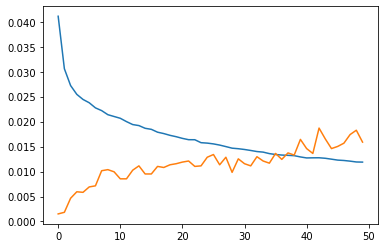

'finished！'

In [24]:
multi_layer(X,Y1,50,'GENSPECTRA','GENSPECTRA')

comparing spectra for NO.0


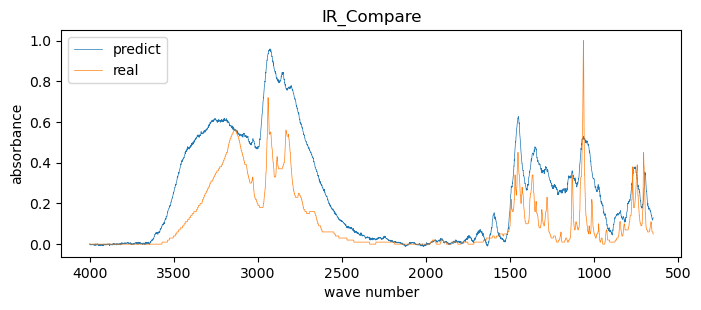

comparing spectra for NO.1


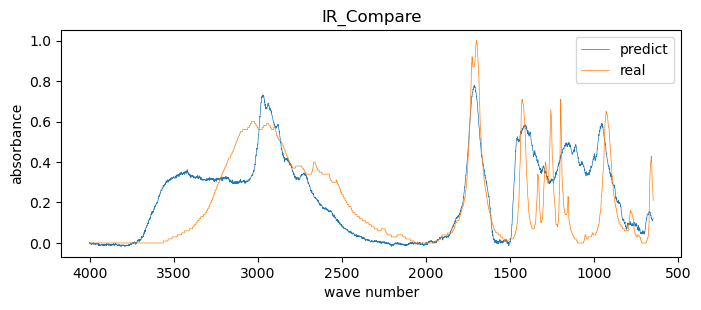

comparing spectra for NO.2


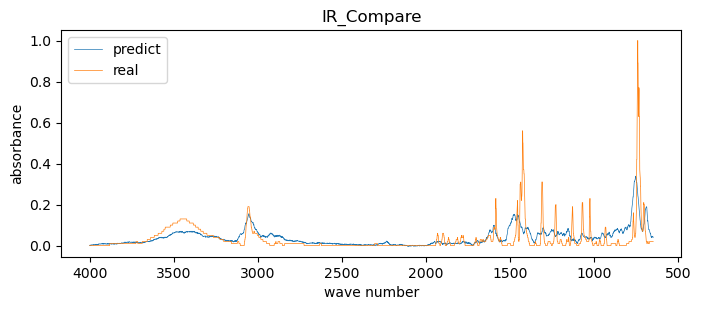

comparing spectra for NO.3


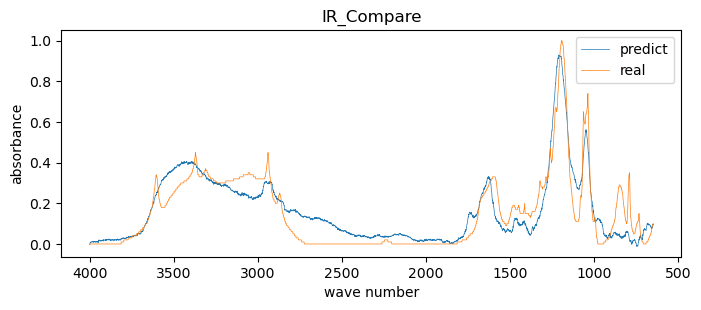

comparing spectra for NO.4


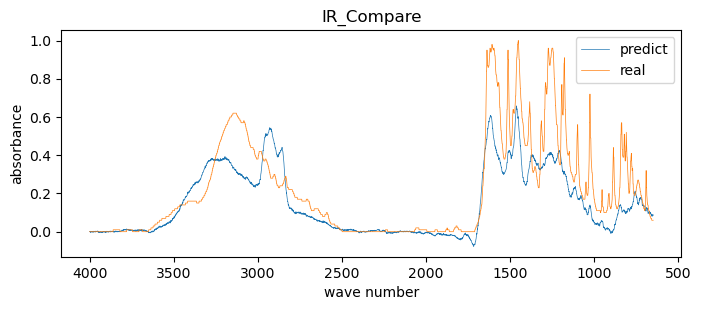

comparing spectra for NO.5


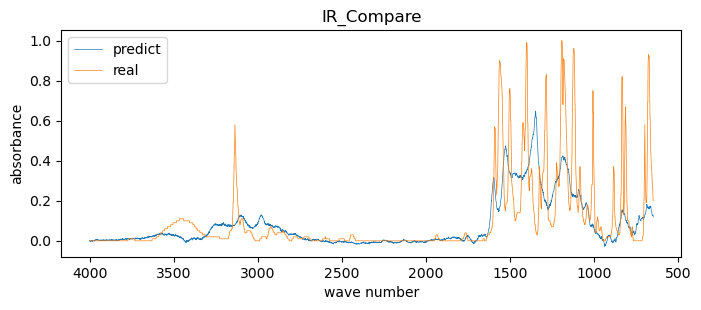

comparing spectra for NO.6


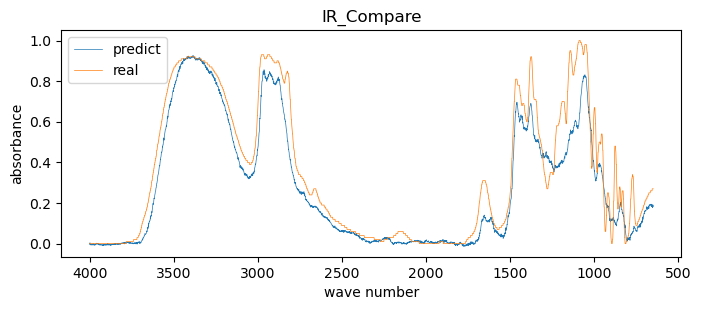

comparing spectra for NO.7


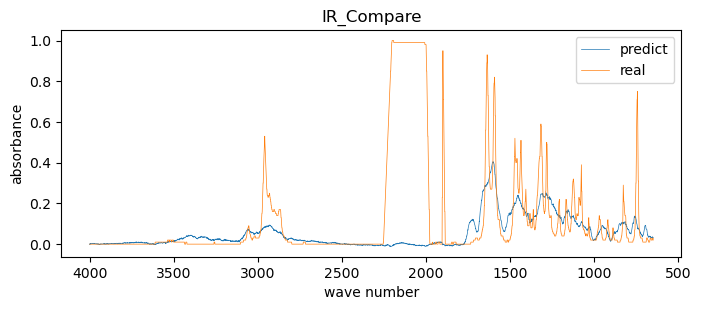

comparing spectra for NO.8


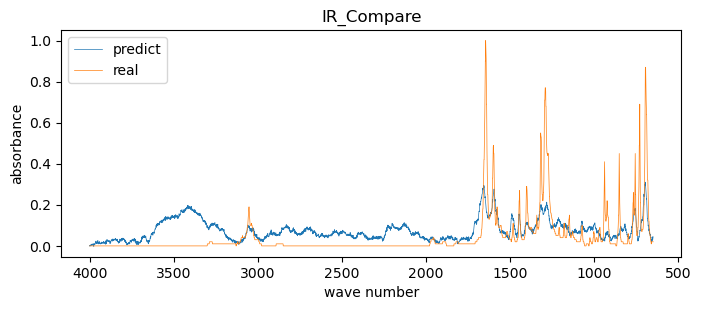

comparing spectra for NO.9


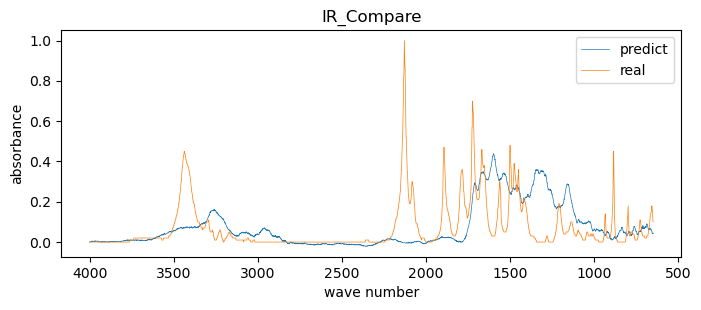

comparing spectra for NO.10


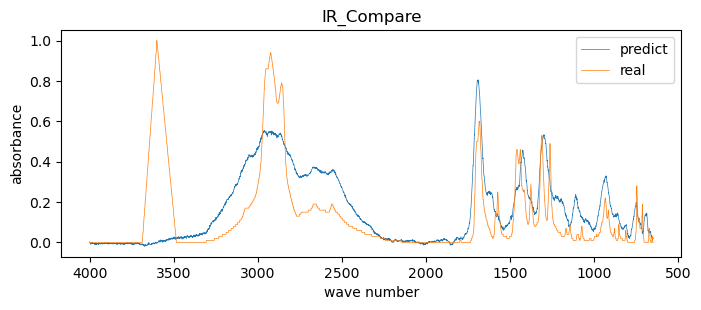

comparing spectra for NO.11


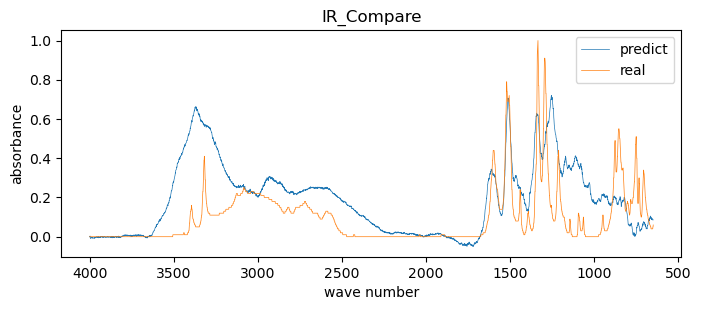

comparing spectra for NO.12


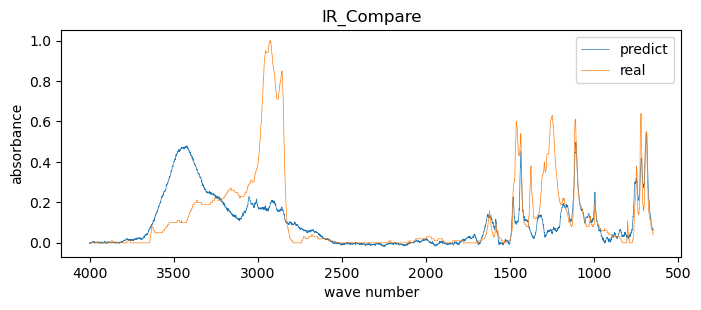

comparing spectra for NO.13


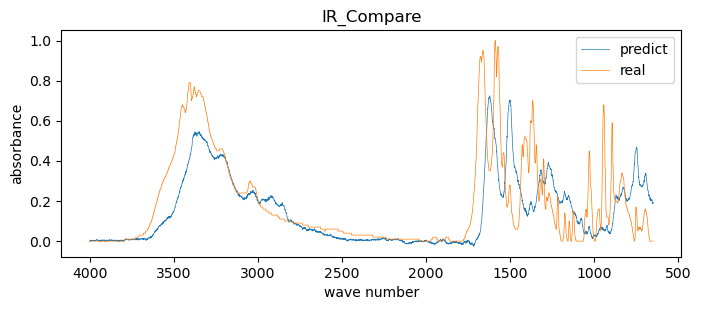

comparing spectra for NO.14


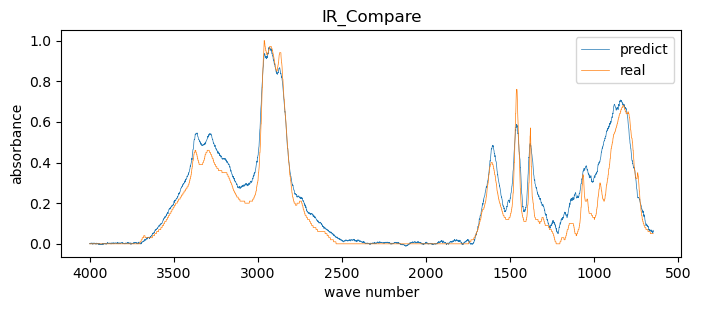

comparing spectra for NO.15


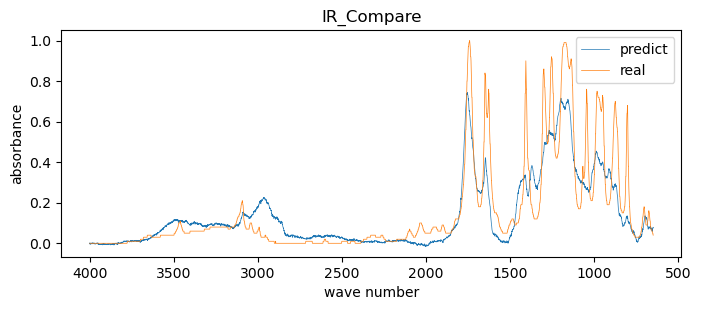

comparing spectra for NO.16


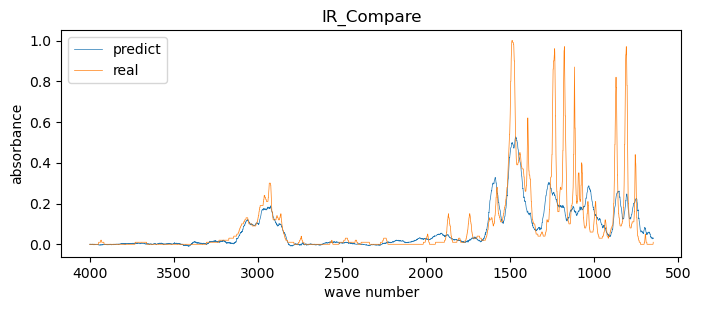

comparing spectra for NO.17


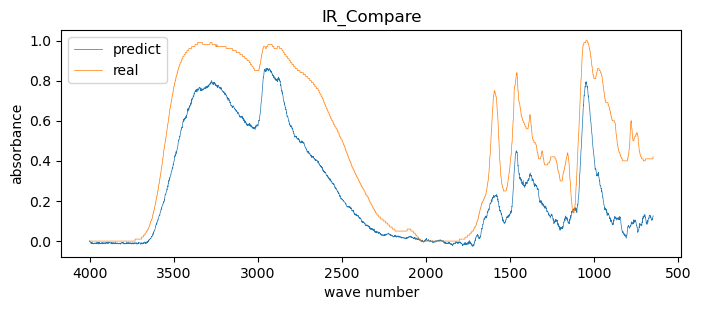

comparing spectra for NO.18


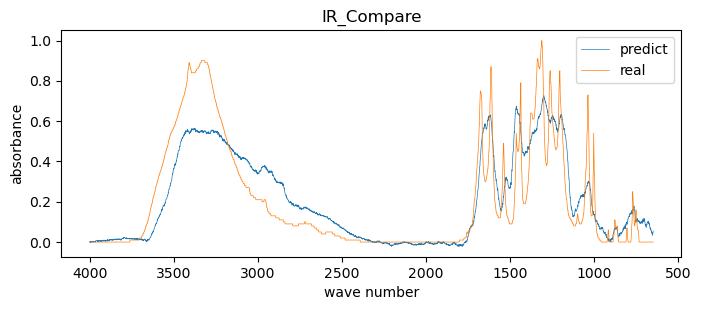

comparing spectra for NO.19


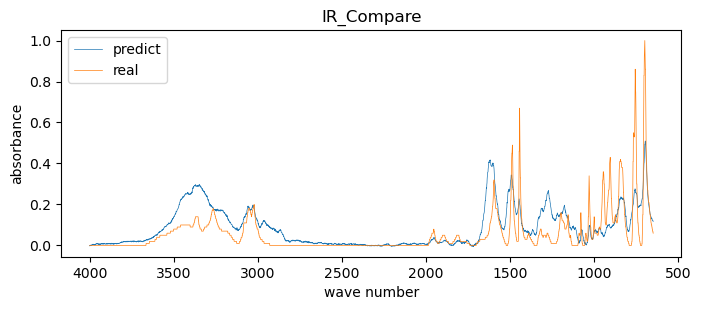

comparing spectra for NO.20


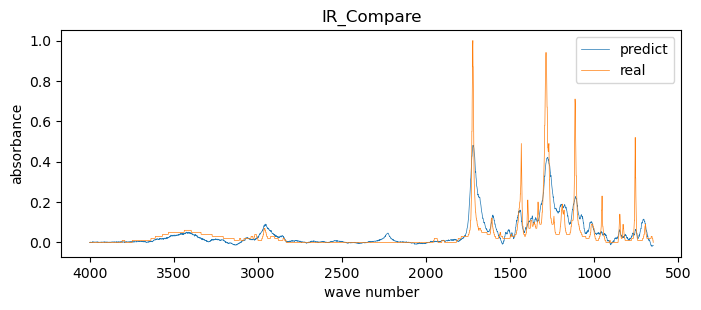

comparing spectra for NO.21


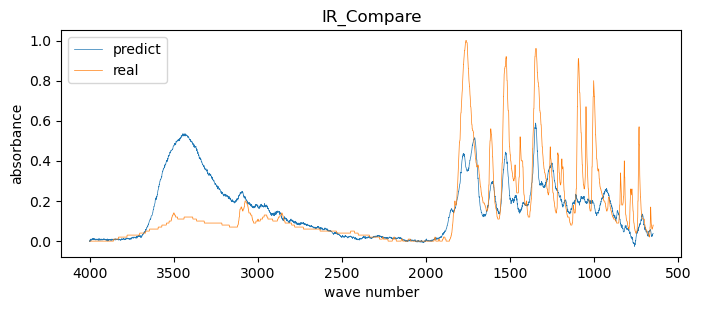

comparing spectra for NO.22


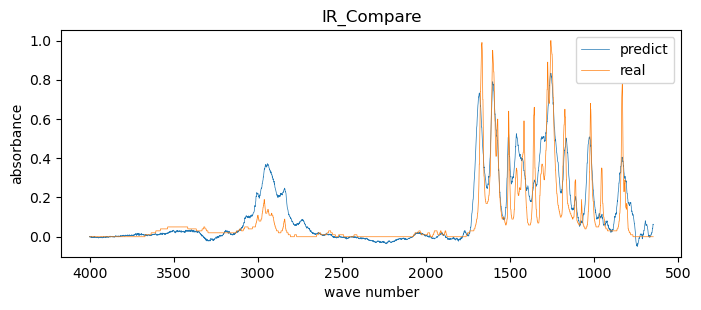

comparing spectra for NO.23


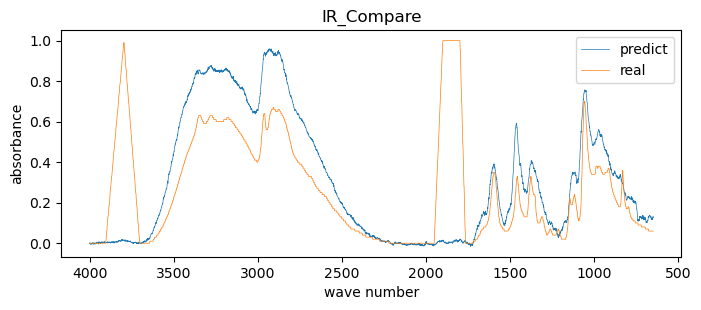

comparing spectra for NO.24


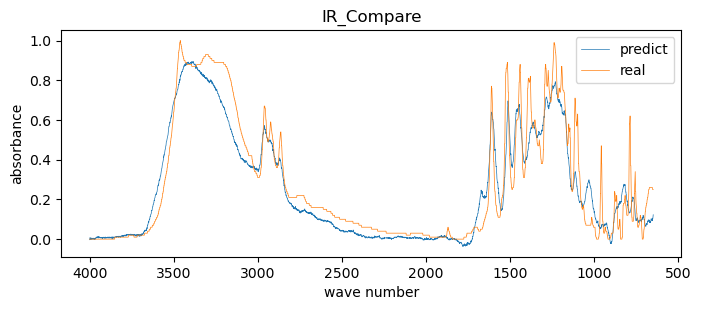

comparing spectra for NO.25


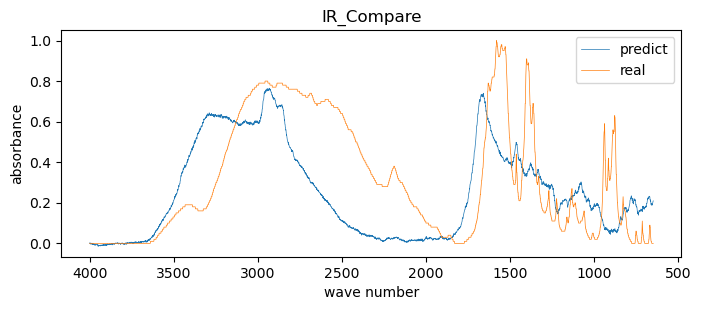

comparing spectra for NO.26


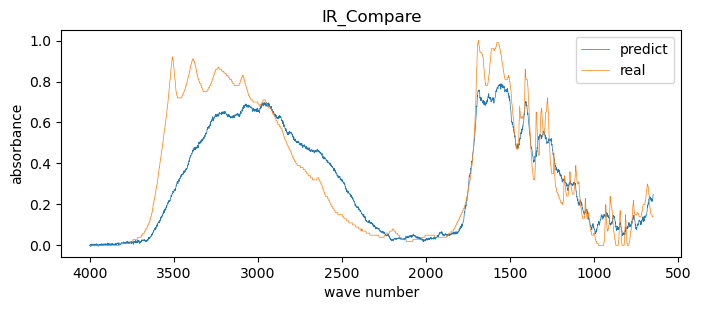

comparing spectra for NO.27


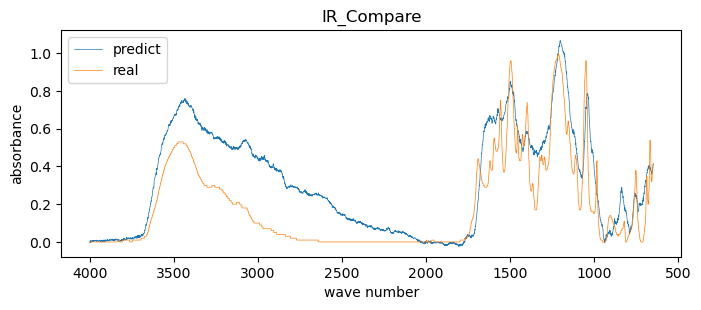

comparing spectra for NO.28


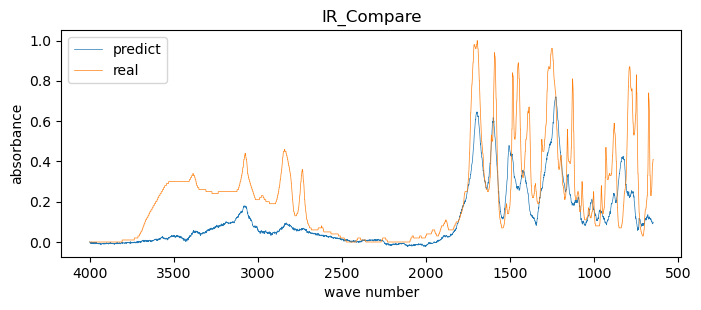

comparing spectra for NO.29


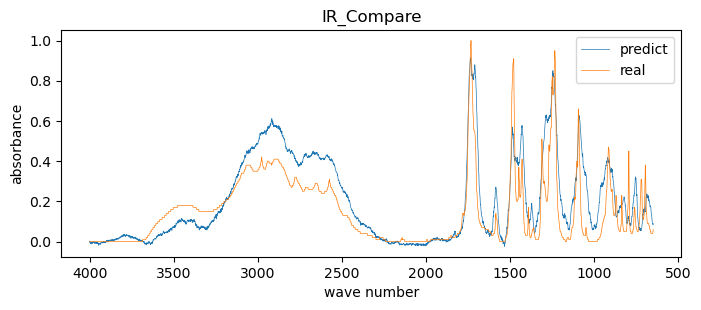

comparing spectra for NO.30


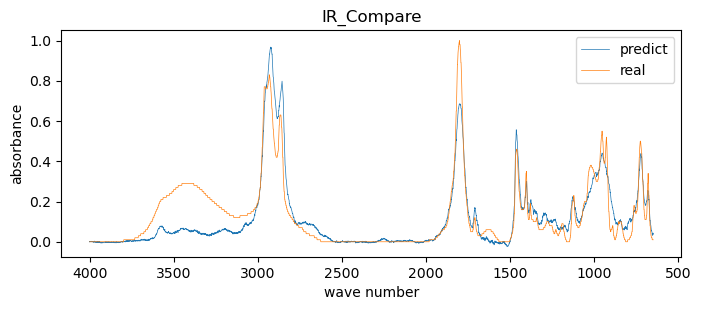

comparing spectra for NO.31


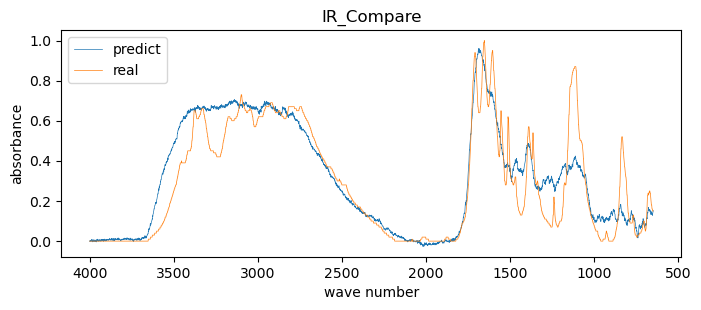

comparing spectra for NO.32


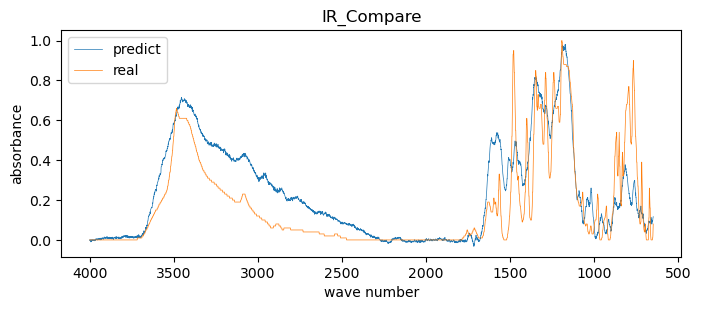

comparing spectra for NO.33


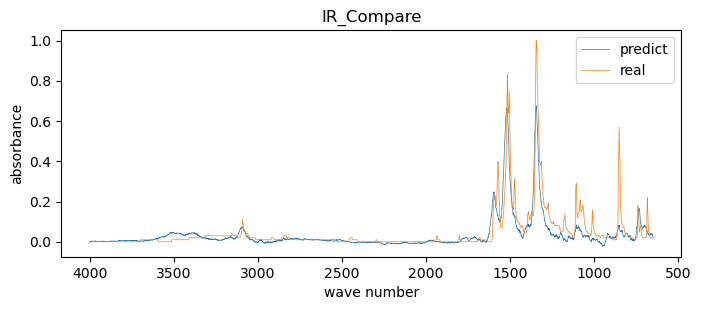

comparing spectra for NO.34


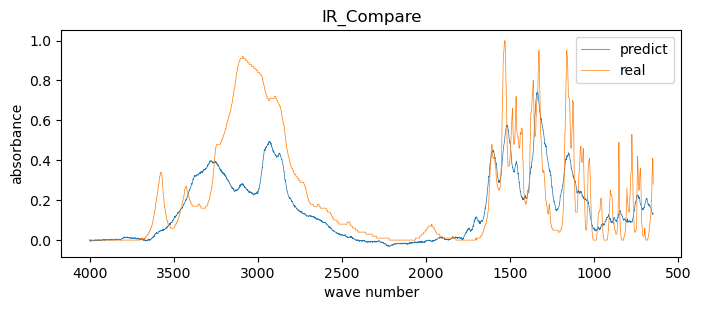

comparing spectra for NO.35


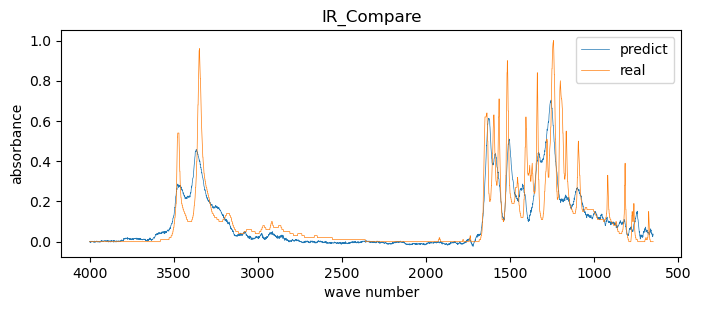

comparing spectra for NO.36


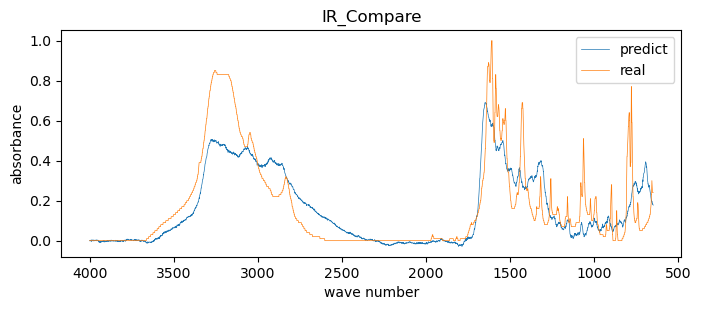

comparing spectra for NO.37


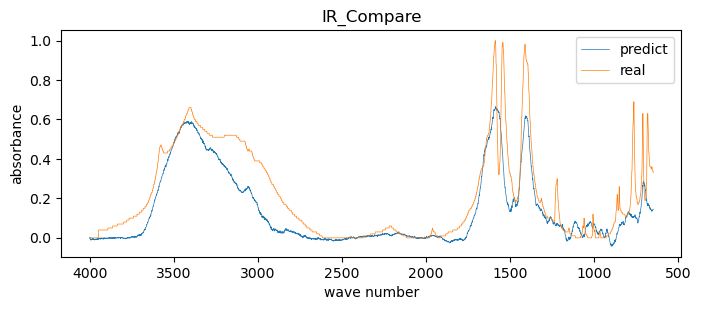

comparing spectra for NO.38


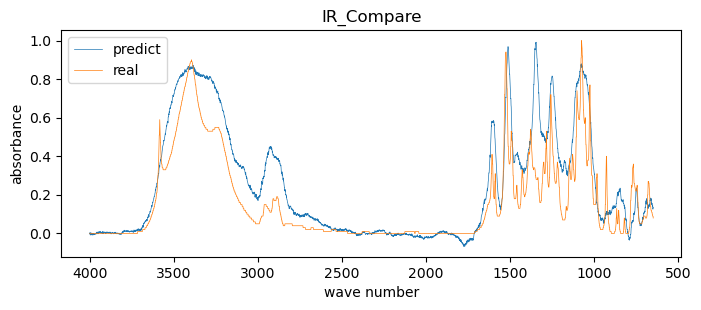

comparing spectra for NO.39


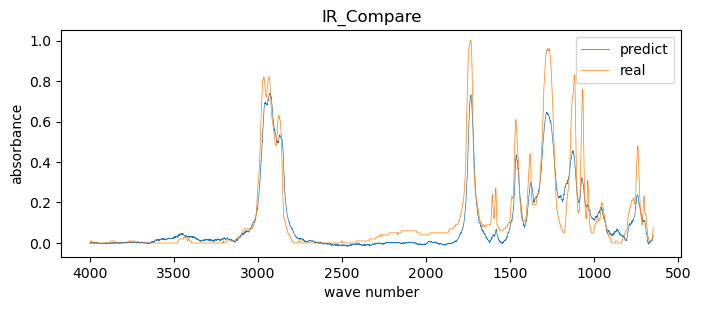

comparing spectra for NO.40


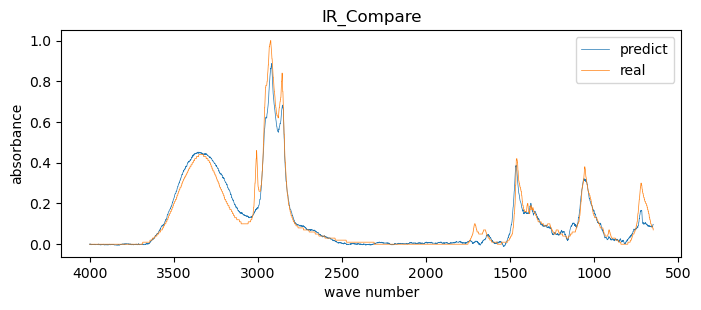

comparing spectra for NO.41


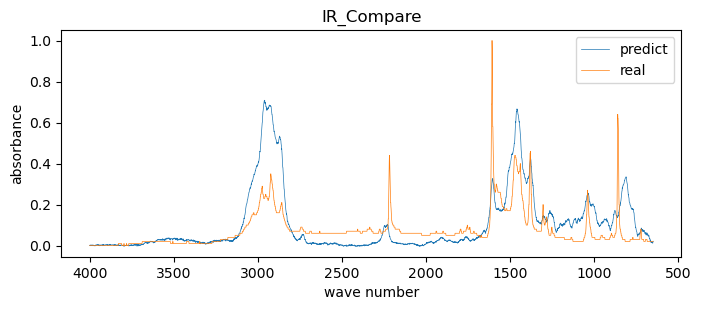

comparing spectra for NO.42


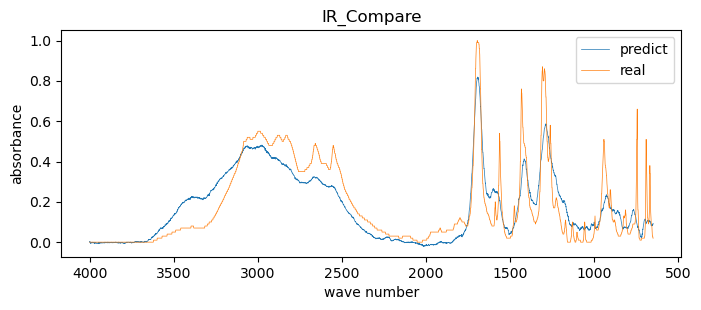

comparing spectra for NO.43


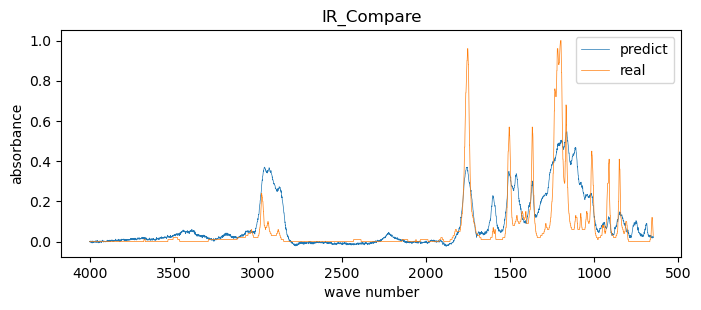

comparing spectra for NO.44


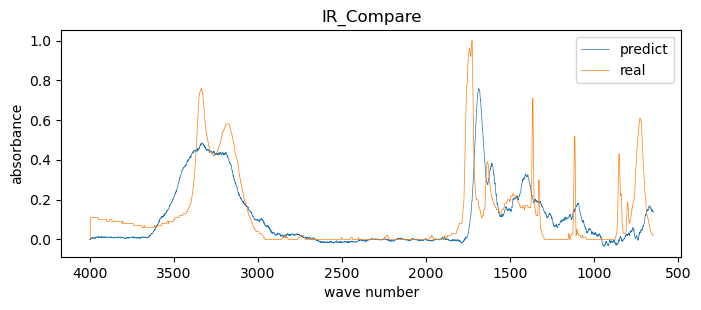

comparing spectra for NO.45


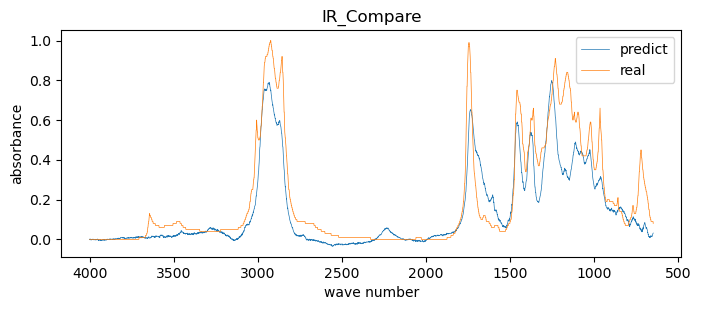

comparing spectra for NO.46


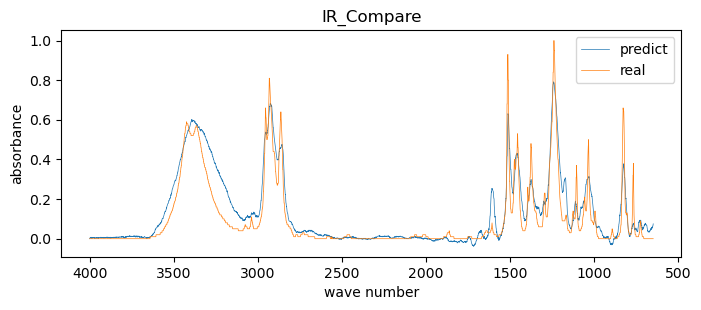

comparing spectra for NO.47


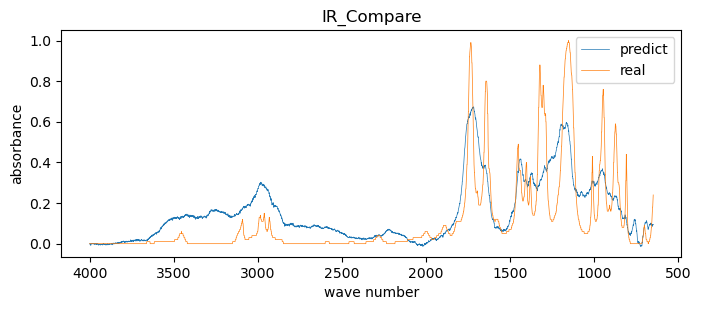

comparing spectra for NO.48


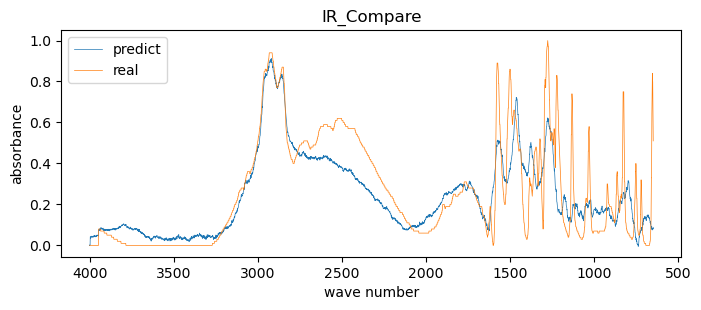

comparing spectra for NO.49


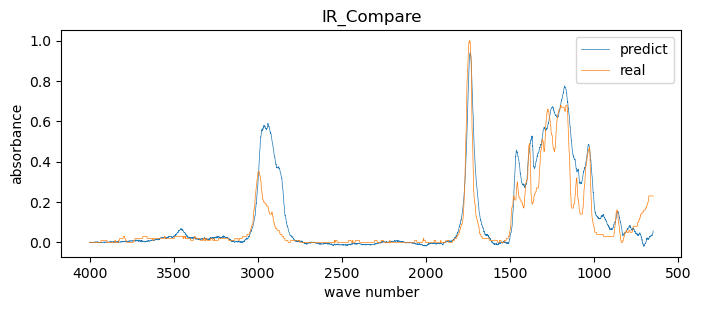

In [25]:
#campare real spectra with calculated spectra using test data
for i in range(0,50):
    print('comparing spectra for NO.'+str(i))
    cal_spectra(TX[i],'GENSPECTRA.h5',TY[i]*0.01)

#real spectra CAS:
7209-00-9
2045-70-7
121-60-8
1592-23-0
629-41-4
376-27-2
142-82-5
91-59-8
80-08-0
41663-73-4
115-96-8
131-54-4
101-77-9
1877-73-2
10318-18-0
106-20-7
115-77-5
109-66-0
120-46-7
4845-58-3
2295-31-0
101-90-6
2041-19-2
56-89-3
123-08-0
114-07-8
1163-19-5
3287-99-8
87-51-4
1333-88-6
58-32-2
5988-19-2
506-30-9
7722-76-1
68-35-9
132-18-3
95-24-9
2305-36-4
87-87-6
504-63-2
637-12-7
67-51-6
66-22-8
2708-97-6
128-09-6
1603-41-4
102-71-6
2623-33-8
2503-56-2
87-44-5


comparing spectra for NO.0


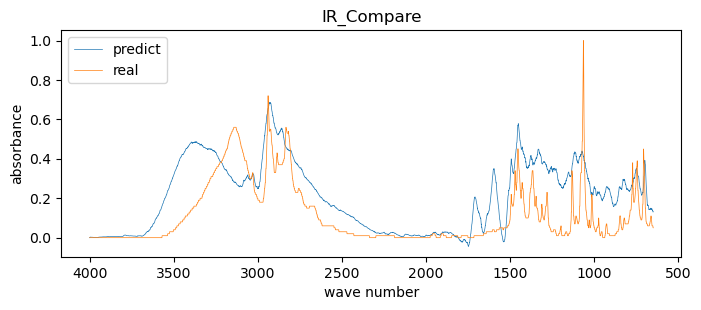

comparing spectra for NO.1


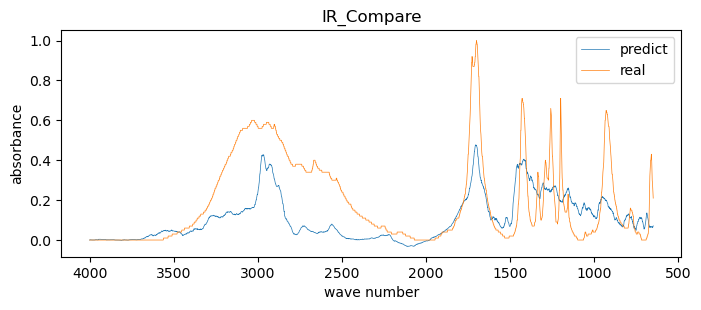

comparing spectra for NO.2


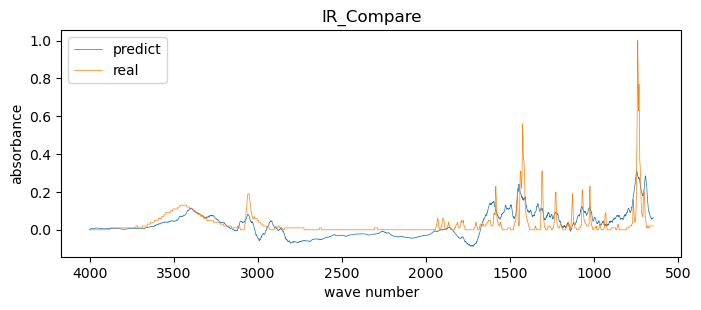

comparing spectra for NO.3


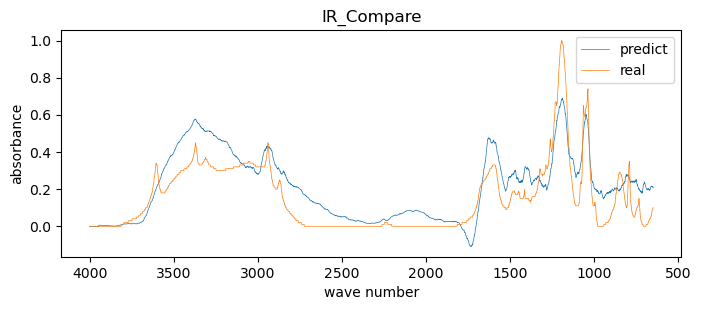

comparing spectra for NO.4


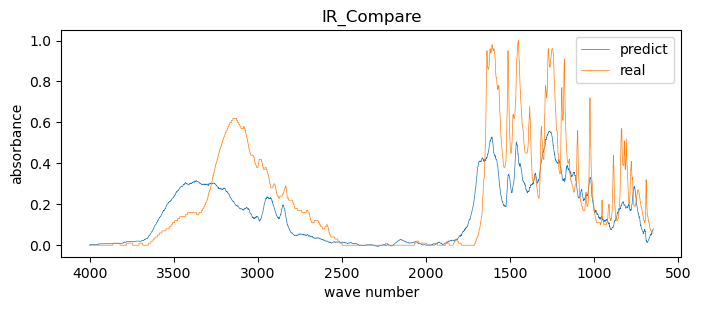

comparing spectra for NO.5


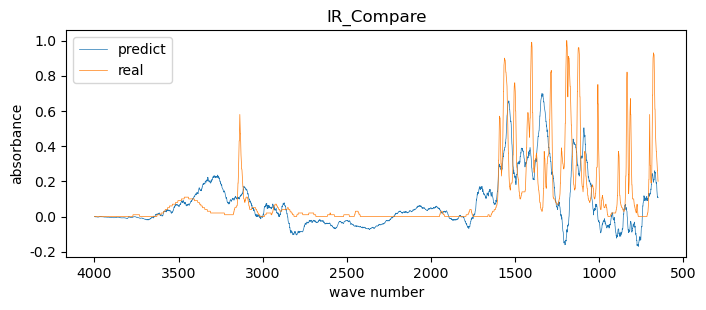

comparing spectra for NO.6


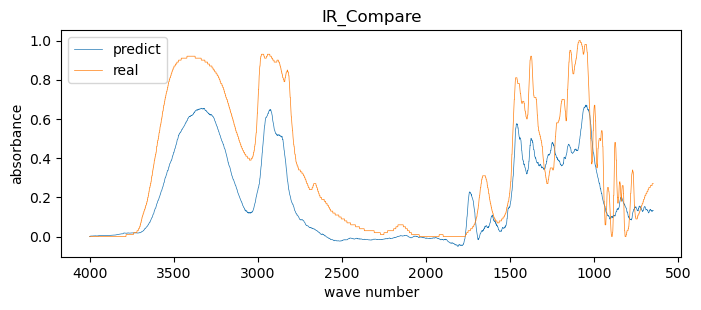

comparing spectra for NO.7


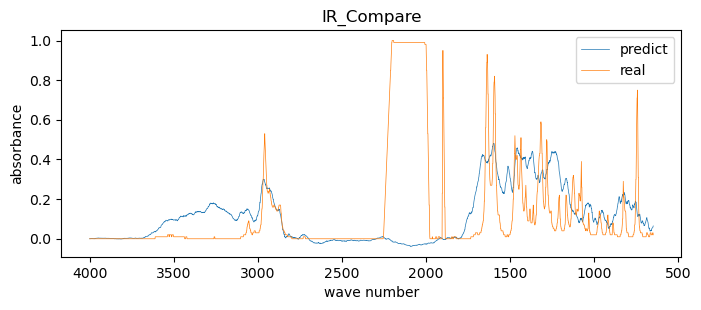

comparing spectra for NO.8


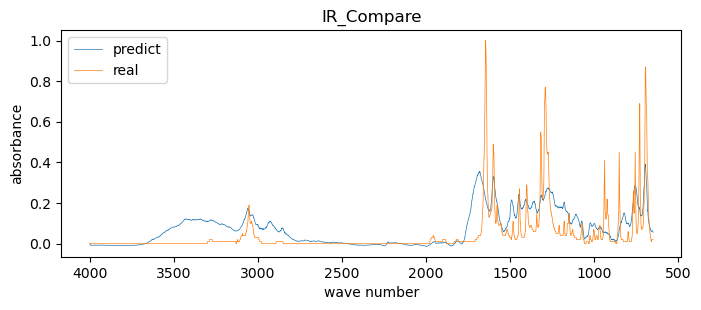

comparing spectra for NO.9


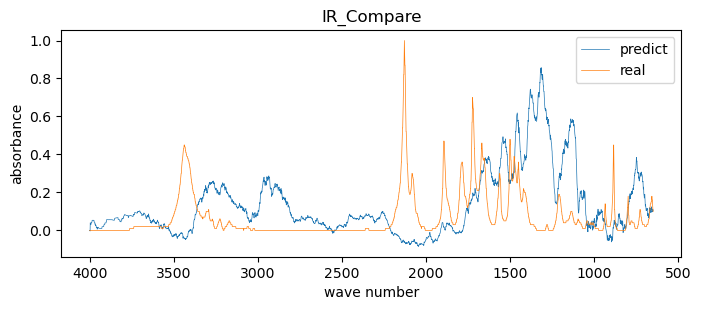

comparing spectra for NO.10


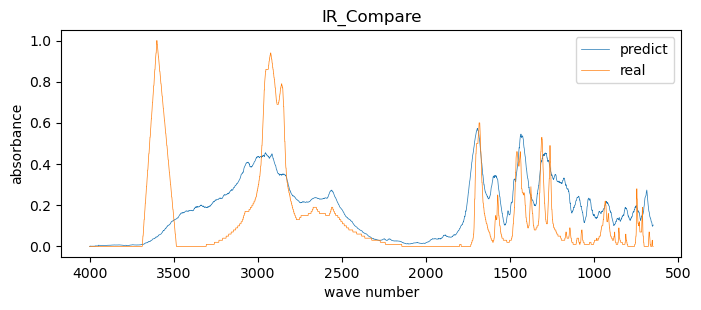

comparing spectra for NO.11


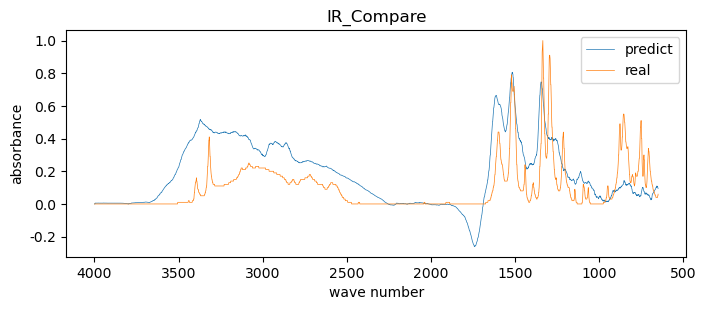

comparing spectra for NO.12


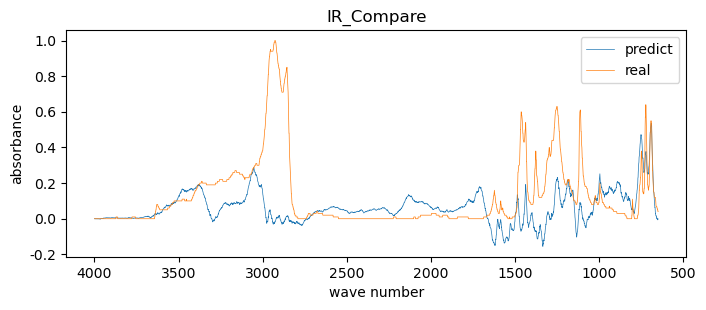

comparing spectra for NO.13


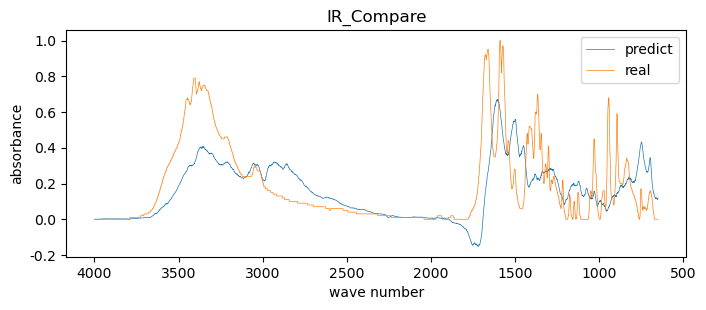

comparing spectra for NO.14


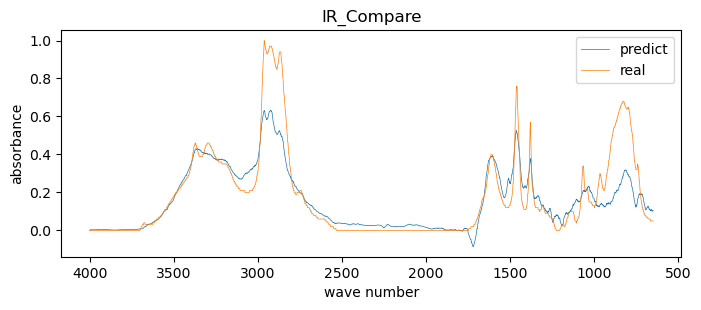

comparing spectra for NO.15


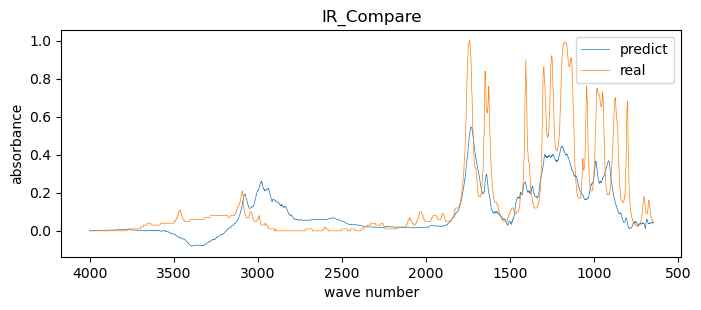

comparing spectra for NO.16


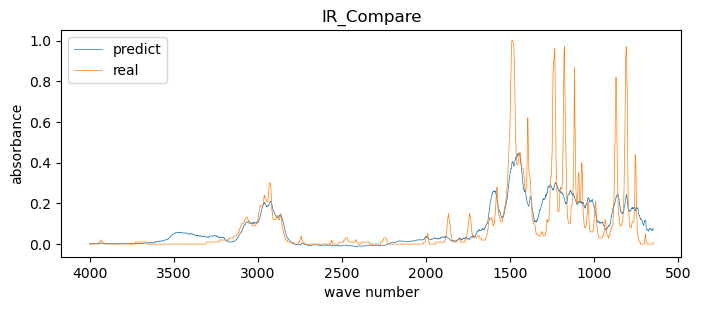

comparing spectra for NO.17


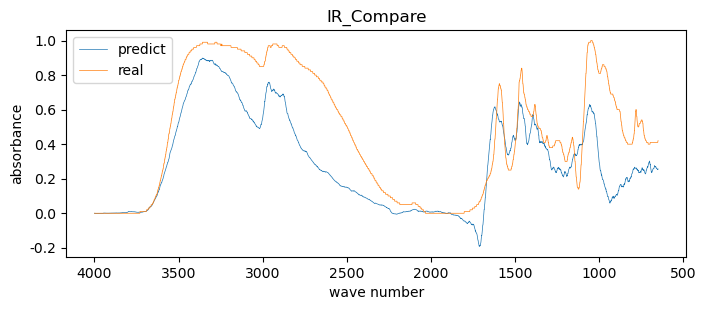

comparing spectra for NO.18


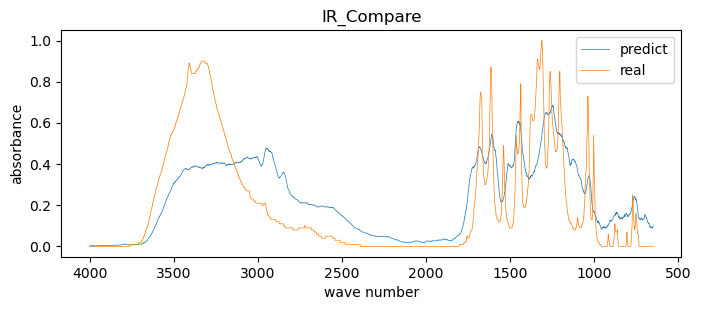

comparing spectra for NO.19


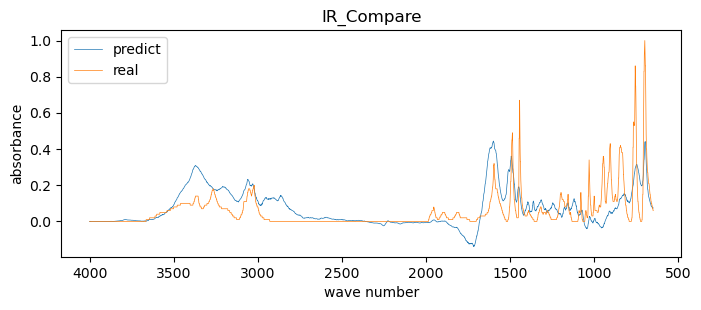

comparing spectra for NO.20


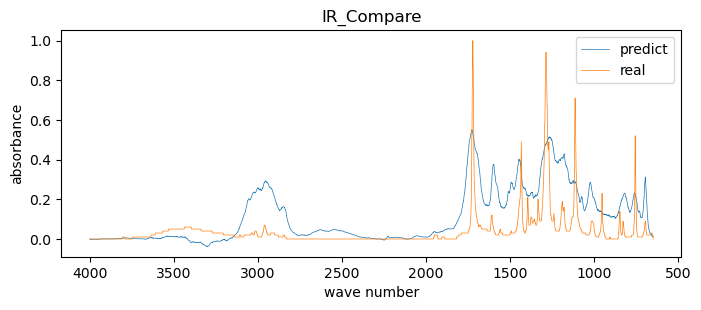

comparing spectra for NO.21


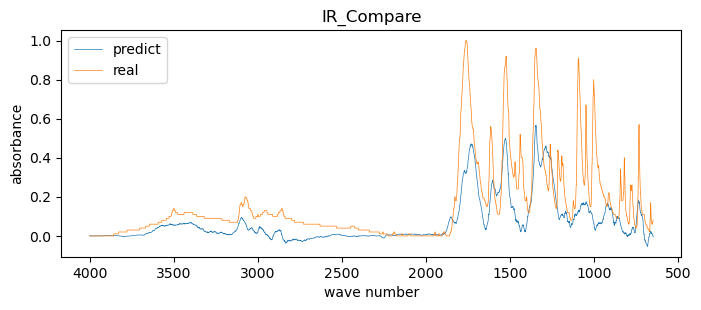

comparing spectra for NO.22


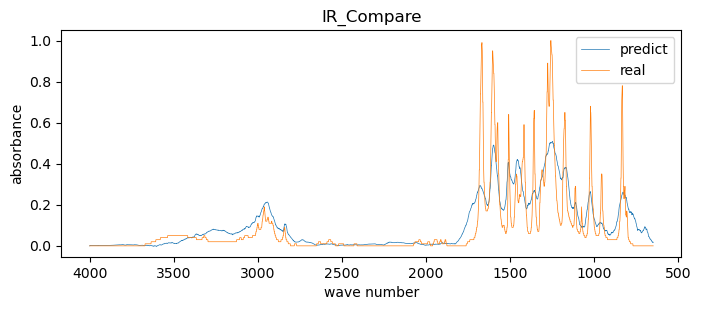

comparing spectra for NO.23


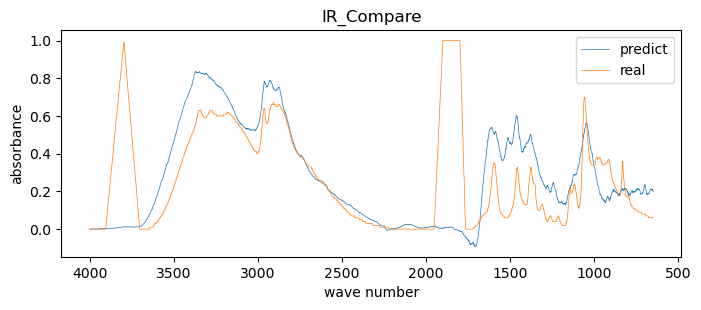

comparing spectra for NO.24


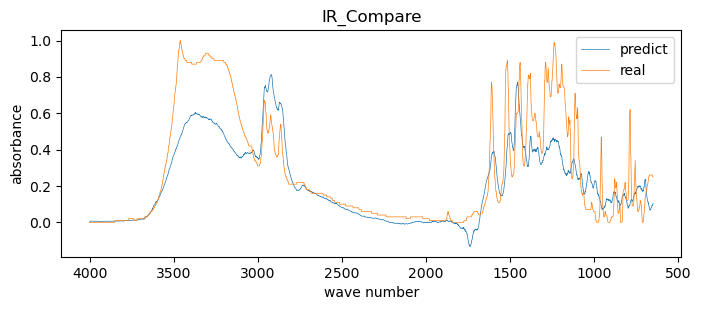

comparing spectra for NO.25


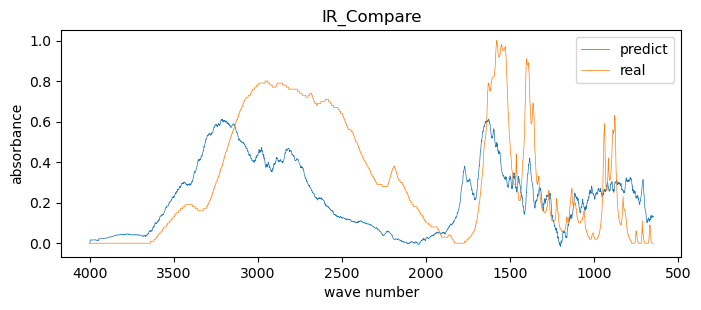

comparing spectra for NO.26


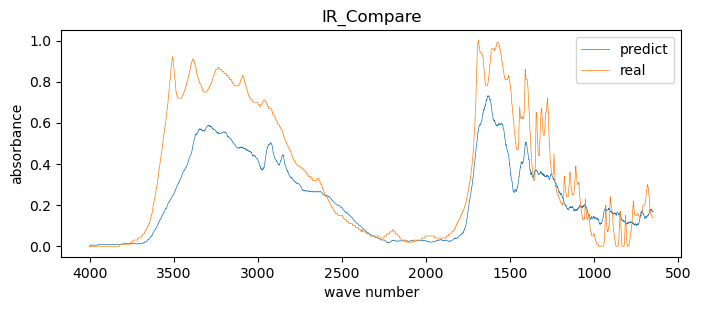

comparing spectra for NO.27


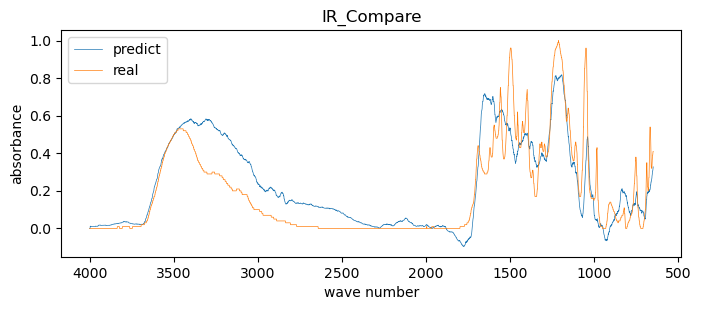

comparing spectra for NO.28


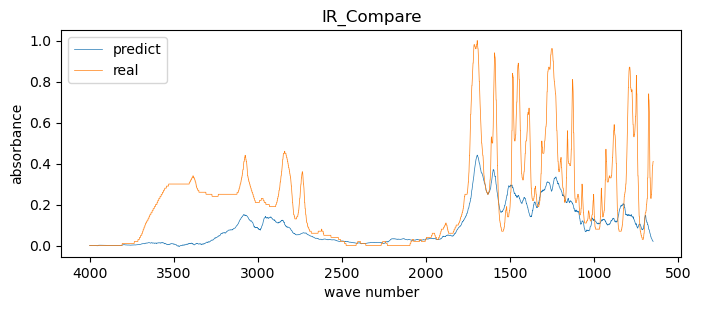

comparing spectra for NO.29


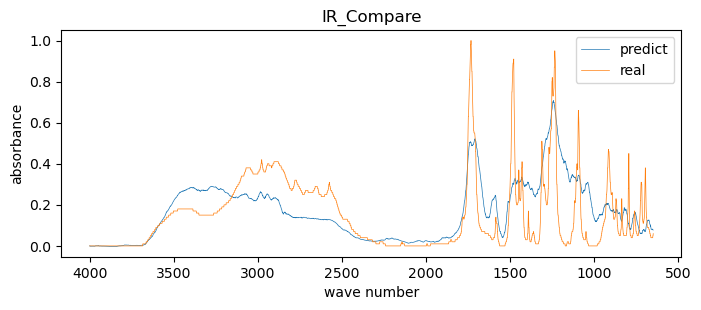

comparing spectra for NO.30


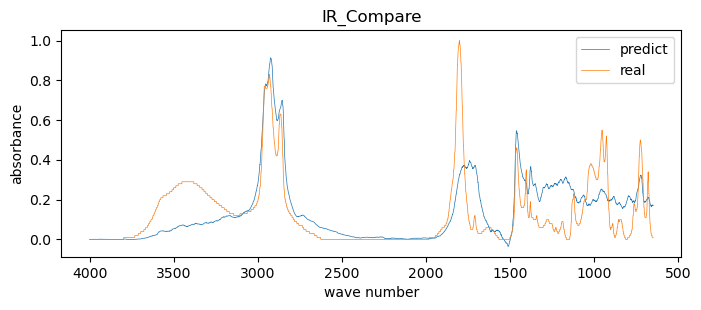

comparing spectra for NO.31


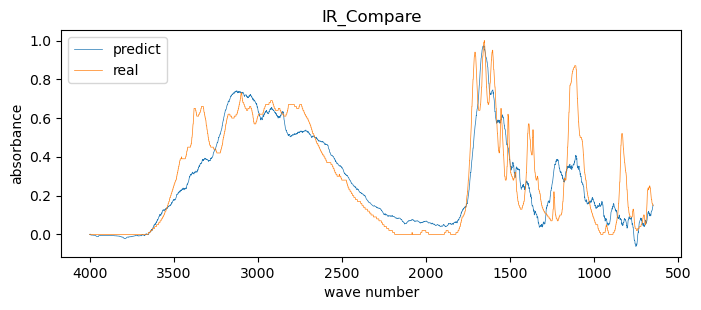

comparing spectra for NO.32


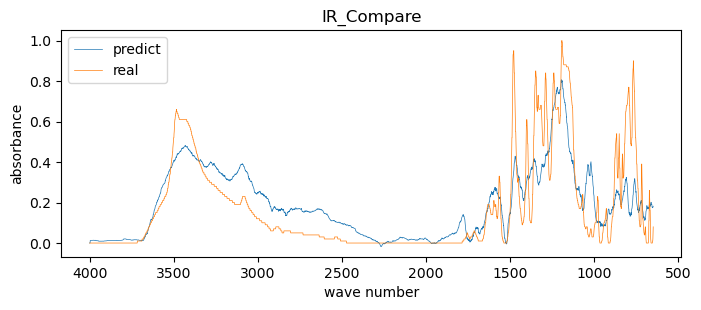

comparing spectra for NO.33


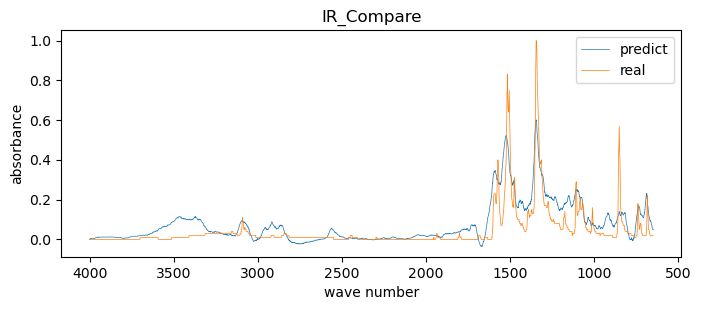

comparing spectra for NO.34


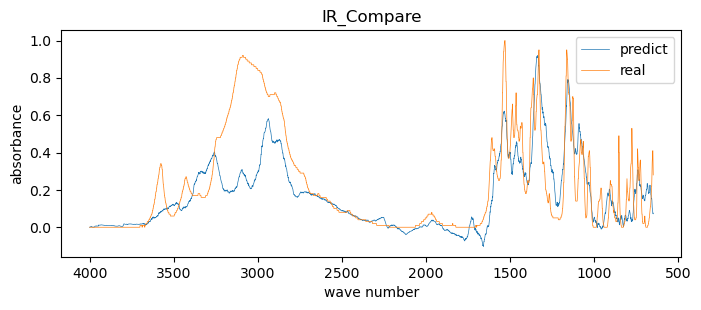

comparing spectra for NO.35


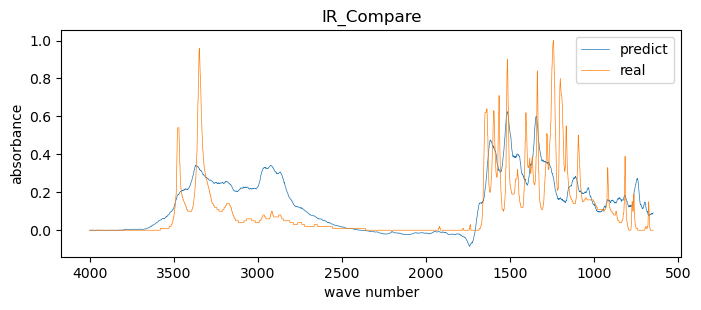

comparing spectra for NO.36


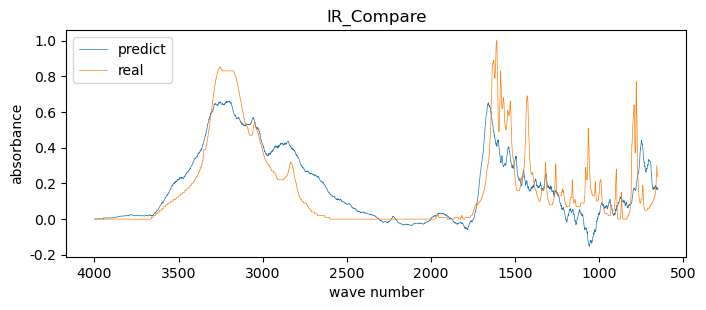

comparing spectra for NO.37


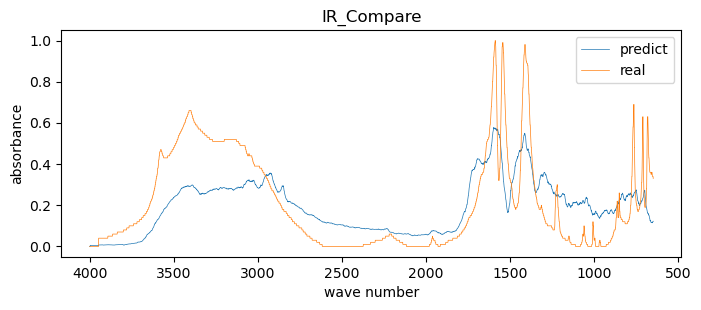

comparing spectra for NO.38


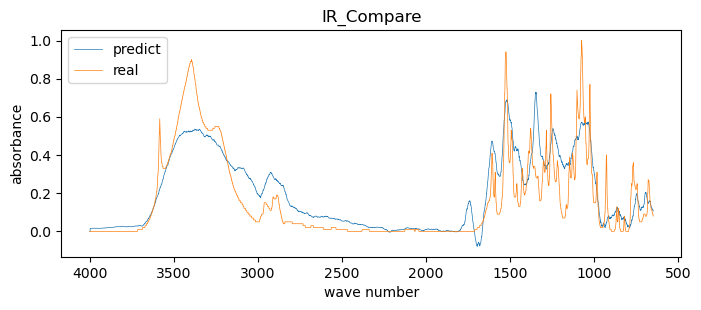

comparing spectra for NO.39


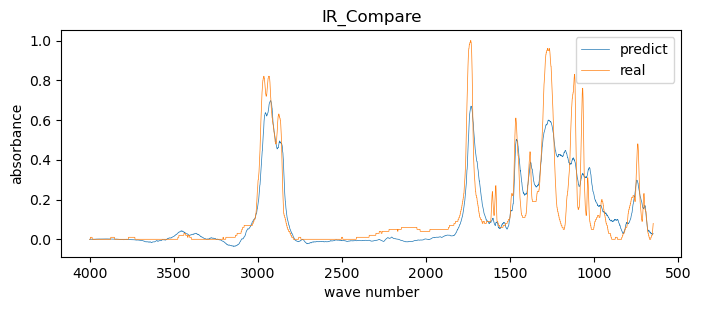

comparing spectra for NO.40


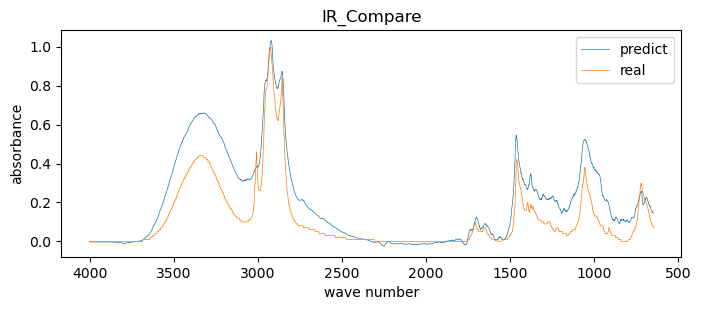

comparing spectra for NO.41


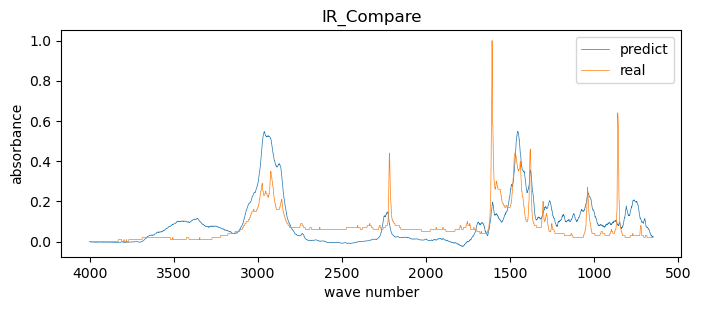

comparing spectra for NO.42


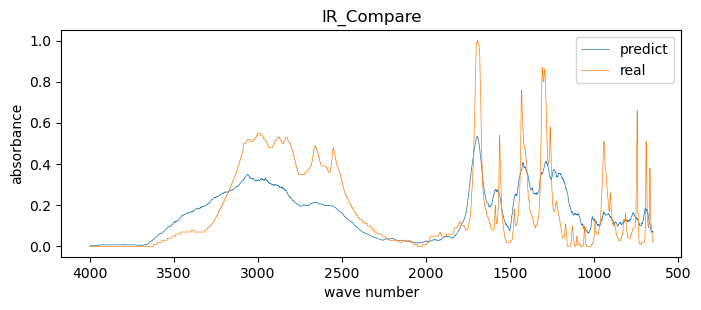

comparing spectra for NO.43


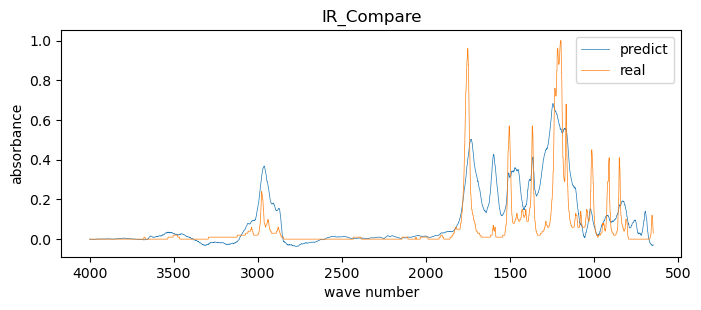

comparing spectra for NO.44


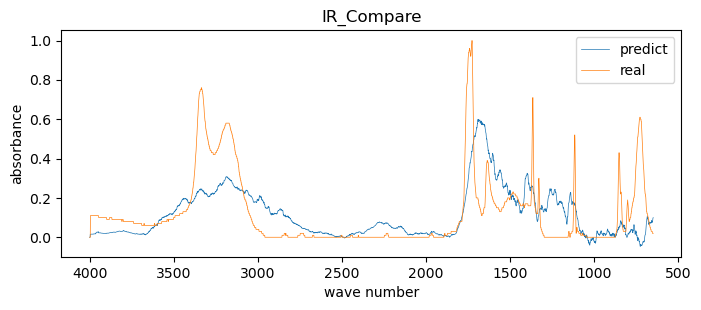

comparing spectra for NO.45


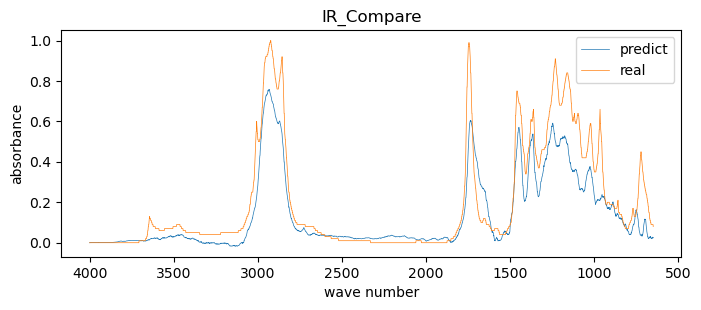

comparing spectra for NO.46


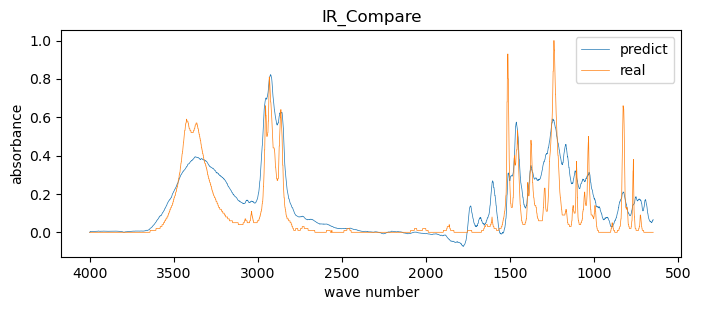

comparing spectra for NO.47


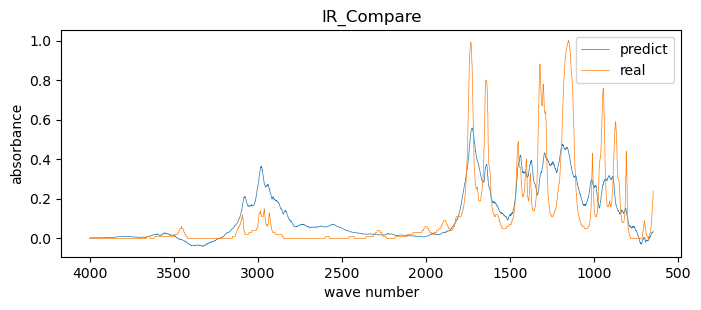

comparing spectra for NO.48


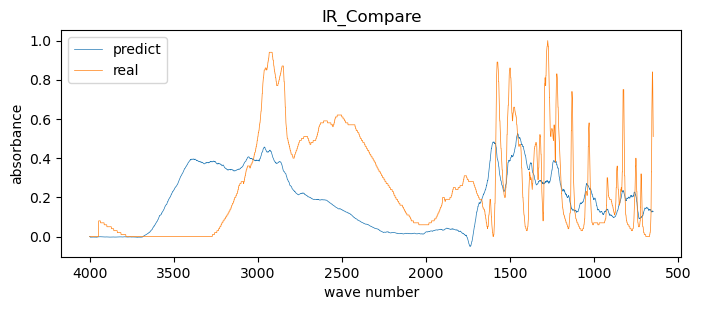

comparing spectra for NO.49


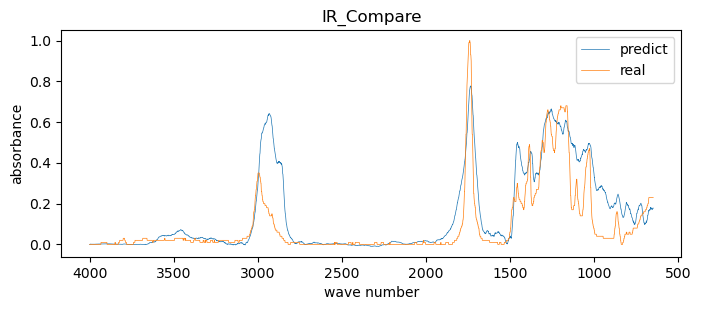

In [26]:
#real vs lsm results
for i in range(0,50):
    print('comparing spectra for NO.'+str(i))
    cal_spectra(TX[i],r_lsm,TY[i]*0.01)